## Import Libraries

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

import cv2
from imageio import imread
import matplotlib.pyplot as plt

%matplotlib inline

## Utility functions

In [18]:
def save_webcam_image(img_path):
    camera = cv2.VideoCapture(0)  # Open webcam (0 = default webcam)
    
    if not camera.isOpened():
        print("❌ Webcam not found or not accessible.")
        return False  # Return False if webcam is not available

    retval, im_camera = camera.read()

    if not retval:  # Check if an image was captured successfully
        print("❌ Failed to capture image from webcam.")
        return False  

    im = cv2.resize(im_camera, (224, 224)).astype(np.float32)  # Resize image
    cv2.imwrite(img_path, im)  # Save image
    camera.release()  # Release the webcam
    return True  # Return True if image is saved successfully

In [32]:
def predict_image(model, img_path, preprocess_input_fn, decode_predictions_fn, target_size=(224, 224)):

    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    
    preds = model.predict(x)
    predictions_df = pd.DataFrame(decode_predictions_fn(preds, top=10)[0])
    predictions_df.columns = ["Predicted Class", "Name", "Probability"]
    return predictions_df

## Show Example Picture

C:\Users\User\AppData\Local\Temp\ipykernel_33240\2918759953.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(img_path))


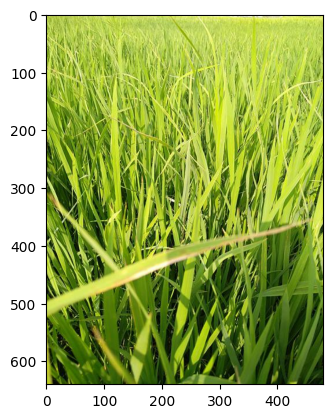

In [24]:
img_path = "D:\\AB-BiMaGOoOD\\DiddyLearning\\Data\\train_images\\bacterial_leaf_blight\\100049.jpg"

plt.imshow(imread(img_path))

## Use Pretrained Model


In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
resnet50_model = ResNet50(weights = 'imagenet')

102967424/102967424 [==============================] - 43s 0us/step


In [31]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
predict_image(resnet50_model, img_path, preprocess_input, decode_predictions)

: 